# Estimating Non-Diagonal Maps using Encoders

In [1]:
import sys
sys.path.append("../../../")
sys.path.append('../../')
import os
import time
import json
import torch
from tqdm import tqdm
from itertools import cycle
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from tqdm import tqdm
import argparse
from torch.nn import functional as F
import matplotlib.pyplot as plt


from potential_flows import transforms, potential, encoders, data, flow
from potential_flows.data import get_dataset, create_custom_dataset
from flow.arguments import set_seed, parse_arguments, parse_notebook_arguments, get_parser

### Example 1: Eight Gaussian Mixture

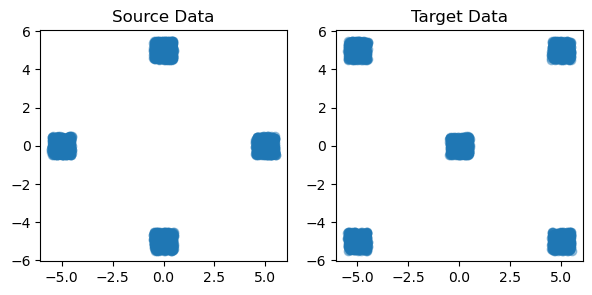

In [2]:
torch.manual_seed(42)
args = parse_notebook_arguments()
args.source_dist = "our_checker"
args.target_dist = "our_checker"
args.verbose = False
args.log_interval = 10

dataset_x, dataset_y = get_dataset(args, split = "train")  ## train dataset
test_x, test_y = get_dataset(args, split = "test")  ## test dataset
fig, axs = plt.subplots(1, 2, figsize = (7,3))
axs[0].scatter(dataset_x.data[:,0], dataset_x.data[:,1], alpha=.4)
axs[0].set_title("Source Data")
axs[1].scatter(dataset_y.data[:,0], dataset_y.data[:,1], alpha=.4)
axs[1].set_title("Target Data")
plt.show()

### Dual Method

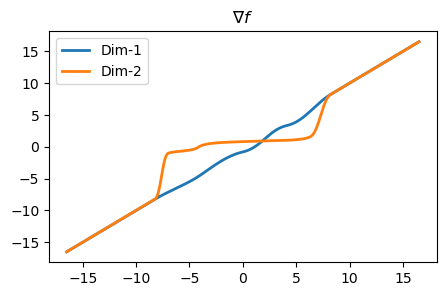

In [3]:
# creating the flow

tail_bound = torch.max(torch.cat([torch.abs(dataset_x.data), torch.abs(dataset_y.data)]))
potential_flow = potential.ICRQ(tail_bound=tail_bound*args.tail_factor, num_bins=4, data_shape=(2,))

# plotting the flow

potential_flow.plot_flow(1000)

In [4]:
# creating data loaders

data_loader_X = DataLoader(dataset_x, batch_size=args.batch_size, shuffle=True)
data_loader_Y = DataLoader(dataset_y, batch_size=args.batch_size, shuffle=True)

# creating OT Trainer

OT_Trainer = flow.DualOT_Trainer(potential_flow, args, dataset_x=data_loader_X, dataset_y=data_loader_Y, test_x=test_x, test_y=test_y)

In [5]:
OT_Trainer.learn()

  0%|          | 0/5000 [00:00<?, ?it/s]/home/medhaaga/miniconda3/envs/nsf/lib/python3.10/site-packages/torch/autograd/__init__.py:394: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  result = Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 5000/5000 [29:22<00:00,  2.84it/s]


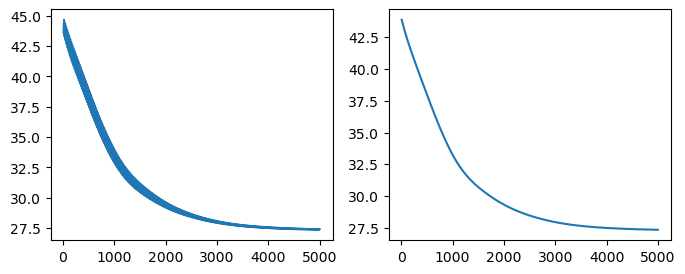

In [7]:
# plotting train and test loss

with open(os.path.join(OT_Trainer.exp_dir, 'training_metrics.json'), "r") as json_file:
    train_specs = json.load(json_file)
train_specs = pd.DataFrame(train_specs)
num_logs = train_specs.shape[0]
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].plot(args.log_interval*(1+np.arange(num_logs)), train_specs['train_loss'])
axs[1].plot(args.log_interval*(1+np.arange(num_logs)), train_specs['test_loss'])
plt.show()

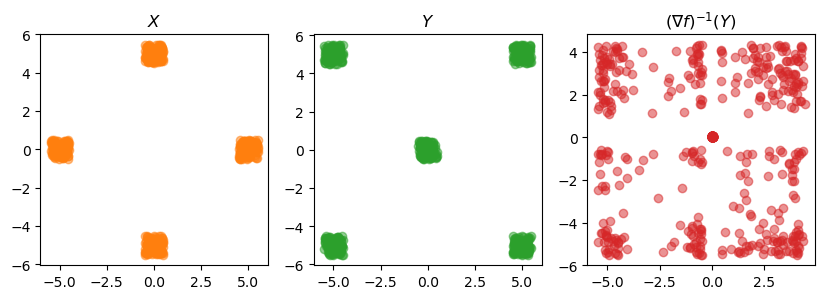

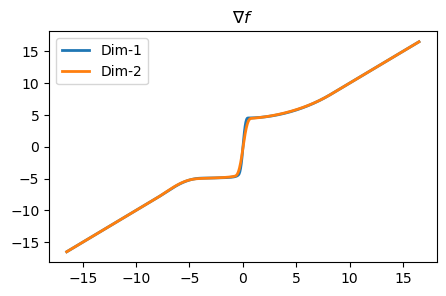

In [8]:
OT_Trainer.args.show_the_plot = True
OT_Trainer.save_figure()
OT_Trainer.args.show_the_plot = False

As expected the diagonal map is unable to transport the checker example considered by Makkuva et. al. Therefore, we explore autoencoders, VAE, and PCA to find a latent distributions for source and target distribution that can be transported by diagonal map (using derivative of a ICRQ spline).

#### Principle Component Analysis

Since the proinciple componenets of the checkerboard data are aligned along the x and y axis, PCA leaves the data unchanged. Therefore, we conduct PCA based encoding for banana distribution.

In [4]:
# load dataset

args.source_dist = "banana"
args.target_dist = "gaussian"
dataset_x, dataset_y = get_dataset(args, split = "train")  ## train dataset
test_x, test_y = get_dataset(args, split = "test")  ## test dataset

# PCA with number of components = 2

n_components = 2
transform_x = encoders.PCA(n_components=n_components).fit(dataset_x.data)
transform_y = encoders.PCA(n_components=n_components).fit(dataset_y.data)

# create flow

tail_bound = args.tail_factor+torch.max(torch.abs(transform_x.encode(dataset_x.data))) + 0.5
potential_flow = potential.ICRQ(tail_bound=tail_bound, num_bins=6, data_shape=(n_components,))

# data loaders

data_loader_X = DataLoader(dataset_x, batch_size=args.batch_size, shuffle=True)
data_loader_Y = DataLoader(dataset_y, batch_size=args.batch_size, shuffle=True)

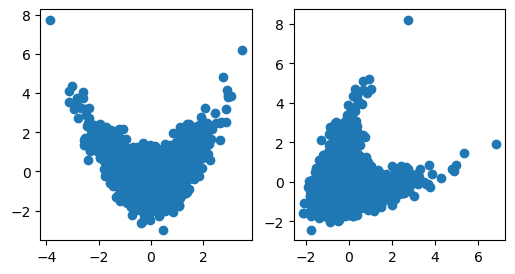

In [5]:
# plot transformed data using PCA

pca_Xtrain = data.CustomDataset(transform_x.encode(dataset_x.data))
fig, axs = plt.subplots(1, 2, figsize = (6,3))
axs[0].scatter(dataset_x.data[:,0], dataset_x.data[:,1])
axs[1].scatter(pca_Xtrain.data[:,0], pca_Xtrain.data[:,1])

In [6]:
PCA_OT_Trainer = flow.DualPCA_OT_Trainer(potential=potential_flow,
                                    transform_x=transform_x,
                                    transform_y=transform_y,
                                    args=args,
                                    dataset_x=data_loader_X,
                                    dataset_y=data_loader_Y,
                                    test_x=test_x,
                                    test_y=test_y)
                                    
# PCA_OT_Trainer.learn() # uncomment to train

In [8]:
PCA_OT_Trainer.encoder_flow = torch.load(PCA_OT_Trainer.exp_dir+'/best_flow.t')

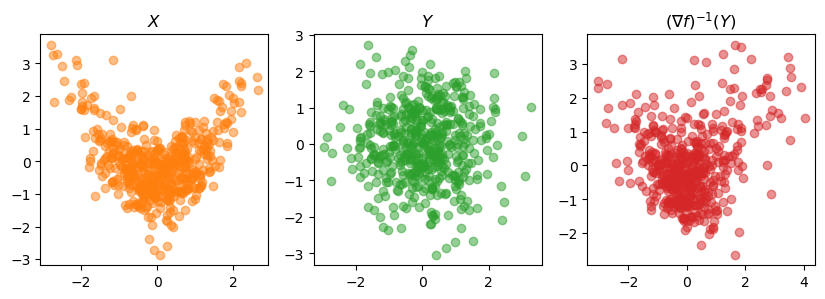

In [9]:
PCA_OT_Trainer.args.show_the_plot = True
PCA_OT_Trainer.generate()

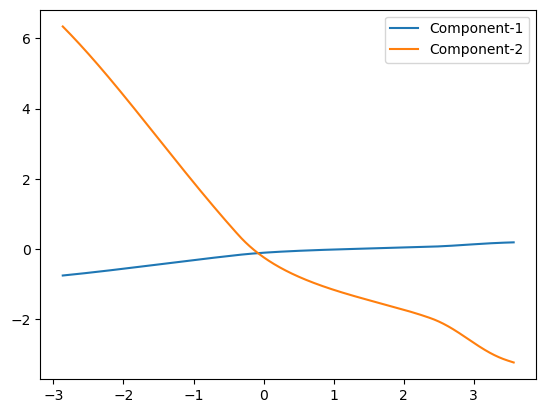

In [10]:
PCA_OT_Trainer.plot_flow()
PCA_OT_Trainer.args.show_the_plot = False

#### Autoencoder Potential Flow

Let us consider the simple case of high dimensional Gaussian and use autoencoders to find a smaller dimensional latent space representation of the source adnd target data. This transformed data is then transported using ICRQ spline based potential flows.

In [4]:
args = parse_notebook_arguments()
args.source_dist = 'gaussian'
args.target_dist = 'gaussian'
d = 1000
args.verbose = False
args.data_shape = (d,)

## create dataset and dataloaders

dataset_x, dataset_y = get_dataset(args, split="train")
test_x, test_y = get_dataset(args, split="test")
data_loader_X = DataLoader(dataset_x, batch_size=args.batch_size, shuffle=True)
data_loader_Y = DataLoader(dataset_y, batch_size=args.batch_size, shuffle=True)


In [12]:
hidden_dim = 512
latent_dim = 10
tail_bound = 1

# create autoencoders for source and target distribution

ae_x = encoders.AE(input_dim=np.prod(args.data_shape), hidden_dim=hidden_dim, latent_dim=latent_dim)
ae_y = encoders.AE(input_dim=np.prod(args.data_shape), hidden_dim=hidden_dim, latent_dim=latent_dim)

# potential flow

potential_flow = potential.ICRQ(tail_bound=tail_bound, num_bins=4, data_shape=(latent_dim,))

# train

AE_OT_Trainer = flow.DualAE_OT_Trainer(potential=potential_flow,
                                        transform_x=ae_x,
                                        transform_y=ae_y,
                                        args=args,
                                        dataset_x=data_loader_X,
                                        dataset_y=data_loader_Y,
                                        test_x=test_x,
                                        test_y=test_y)
                                        
# AE_OT_Trainer.learn() # uncomment to learn

100%|██████████| 5000/5000 [1:22:03<00:00,  1.02it/s]


In [ ]:
# plotting train and test loss

with open(os.path.join(AE_OT_Trainer.exp_dir, 'training_metrics.json'), "r") as json_file:
    train_specs = json.load(json_file)
train_specs = pd.DataFrame(train_specs)
num_logs = train_specs.shape[0]
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].plot(args.log_interval*(1+np.arange(num_logs)), train_specs['train_loss'])
axs[1].plot(args.log_interval*(1+np.arange(num_logs)), train_specs['test_loss'])
plt.show()

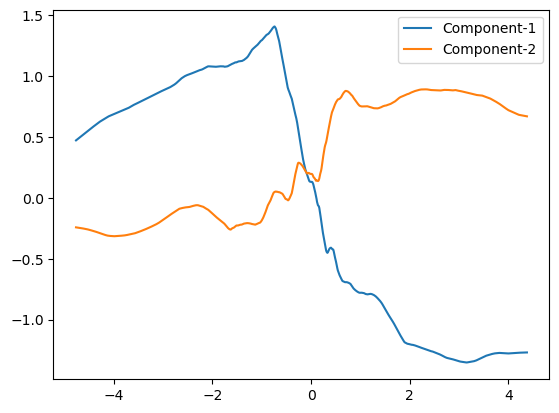

In [13]:
AE_OT_Trainer.args.show_the_plot = True
AE_OT_Trainer.plot_flow()

#### Learning OT using Simple Encoders

We use two encoders $T_1: \mathbb{R}^d \to \mathbb{R}^p $ and $T_2: \mathbb{R}^d \to \mathbb{R}^p $ and minimize the semi-dual loss
$$\min_{f, T_1, T_2}\frac{1}{n} \sum_{i=1}^n \left(f(T_1(X_i)) + f^*(T_2(Y_i))\right)$$

Further we learn two decoders $S_1: \mathbb{R}^p \to \mathbb{R}^d $ and $S_2: \mathbb{R}^p \to \mathbb{R}^d $ by minimizing their respective reconstruction loss with $T_1$ and $T_2$.

In [5]:
hidden_dim = 512
latent_dim = 10
tail_bound = 1
args.show_the_plot = False

# create encoders for source and target distribution

encoder_x = encoders.Encoder(input_dim=np.prod(args.data_shape), hidden_dim=hidden_dim, latent_dim=latent_dim)
encoder_y = encoders.Encoder(input_dim=np.prod(args.data_shape), hidden_dim=hidden_dim, latent_dim=latent_dim)

# potential flow

potential_flow = potential.ICRQ(tail_bound=tail_bound, num_bins=4, data_shape=(latent_dim,))

# train

Encoder_OT_Trainer = flow.DualEncoder_OT_Trainer(potential=potential_flow,
                                            encoder_x=encoder_x,
                                            encoder_y=encoder_y,
                                            args=args,
                                            dataset_x=data_loader_X,
                                            dataset_y=data_loader_Y,
                                            test_x=test_x,
                                            test_y=test_y)
# Encoder_OT_Trainer.learn()

In [6]:
Encoder_OT_Trainer.encoder_flow = torch.load(Encoder_OT_Trainer.exp_dir+'/best_flow.t')

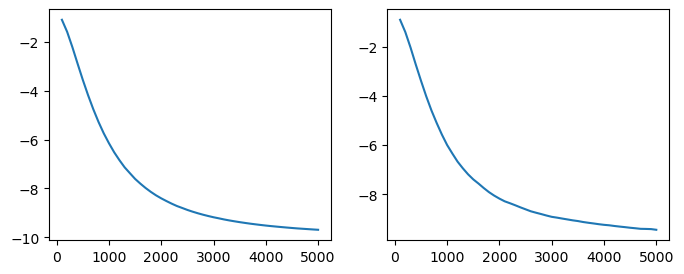

In [7]:
# plotting train and test loss

with open(os.path.join(Encoder_OT_Trainer.exp_dir, 'training_metrics.json'), "r") as json_file:
    train_specs = json.load(json_file)
train_specs = pd.DataFrame(train_specs)
num_logs = train_specs.shape[0]
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].plot(args.log_interval*(1+np.arange(num_logs)), train_specs['train_loss'])
axs[1].plot(args.log_interval*(1+np.arange(num_logs)), train_specs['test_loss'])
plt.show()

In [8]:
decoder_x, decoder_y = Encoder_OT_Trainer.learn_decoders(epochs=1024, learning_rate=0.05)

  0%|          | 0/1024 [00:00<?, ?it/s]/home/medhaaga/miniconda3/envs/nsf/lib/python3.10/site-packages/torch/autograd/__init__.py:251: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  0%|          | 4/1024 [00:00<00:54, 18.77it/s]

Epoch: 0, loss: 475204.28125


 10%|█         | 104/1024 [00:06<00:56, 16.25it/s]

Epoch: 100, loss: 463591.3125


 20%|█▉        | 203/1024 [00:11<00:44, 18.45it/s]

Epoch: 200, loss: 463582.28125


 30%|██▉       | 303/1024 [00:17<00:45, 15.81it/s]

Epoch: 300, loss: 462085.0625


 39%|███▉      | 403/1024 [00:23<00:39, 15.55it/s]

Epoch: 400, loss: 462925.375


 49%|████▉     | 503/1024 [00:30<00:32, 15.81it/s]

Epoch: 500, loss: 462859.125


 59%|█████▉    | 603/1024 [00:35<00:24, 17.52it/s]

Epoch: 600, loss: 462830.5625


 69%|██████▊   | 703/1024 [00:41<00:17, 18.06it/s]

Epoch: 700, loss: 463271.1875


 79%|███████▊  | 804/1024 [00:47<00:13, 16.89it/s]

Epoch: 800, loss: 465580.9375


 88%|████████▊ | 904/1024 [00:53<00:06, 17.70it/s]

Epoch: 900, loss: 463969.625


 98%|█████████▊| 1004/1024 [00:59<00:01, 17.34it/s]

Epoch: 1000, loss: 462051.9375


  0%|          | 4/1024 [00:00<00:55, 18.32it/s]

Epoch: 0, loss: 465739.75


 10%|█         | 104/1024 [00:05<00:51, 17.91it/s]

Epoch: 100, loss: 463880.375


 20%|█▉        | 203/1024 [00:11<00:43, 18.81it/s]

Epoch: 200, loss: 464987.59375


 30%|██▉       | 303/1024 [00:17<00:40, 17.93it/s]

Epoch: 300, loss: 462795.0


 39%|███▉      | 403/1024 [00:23<00:37, 16.51it/s]

Epoch: 400, loss: 464021.9375


 49%|████▉     | 503/1024 [00:30<00:34, 15.11it/s]

Epoch: 500, loss: 463253.09375


 59%|█████▉    | 603/1024 [00:35<00:26, 15.92it/s]

Epoch: 600, loss: 463882.21875


 69%|██████▊   | 703/1024 [00:41<00:18, 17.35it/s]

Epoch: 700, loss: 463212.46875


 78%|███████▊  | 803/1024 [00:47<00:14, 15.20it/s]

Epoch: 800, loss: 464893.8125


 88%|████████▊ | 903/1024 [00:54<00:08, 14.52it/s]

Epoch: 900, loss: 463348.75


 98%|█████████▊| 1003/1024 [01:00<00:01, 16.60it/s]

Epoch: 1000, loss: 464515.3125


100%|██████████| 1024/1024 [01:01<00:00, 16.62it/s]


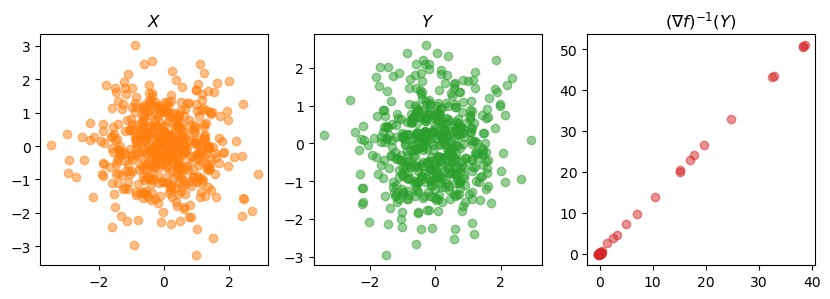

In [13]:
Encoder_OT_Trainer.args.show_the_plot = True
Encoder_OT_Trainer.generate(decoder_x=decoder_x)


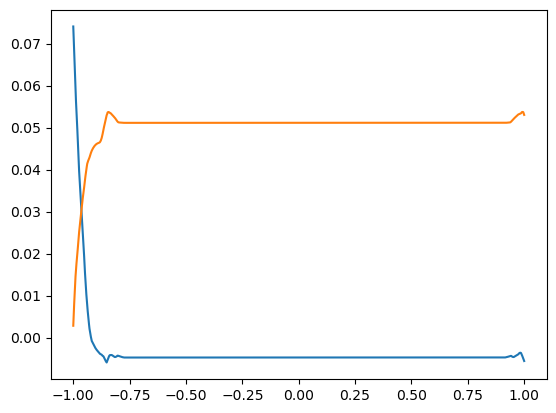

In [27]:
# plot flow

x = torch.linspace(-1, 1, 1000)
x = torch.cat([x.unsqueeze(-1)]*np.prod(Encoder_OT_Trainer.args.data_shape), dim=1)
with torch.no_grad():
    y = Encoder_OT_Trainer.encoder_flow.encode_x(x)
    y = Encoder_OT_Trainer.encoder_flow.potential.gradient(y)
    y = decoder_y(y)
for i in [0,1]:
    plt.plot(x[:,i], y[:,i], label='Component-{}'.format(i+1))


#### Variational Autoencoders

Unfortunately, VAE suffers the same issues as autoencoders.

In [ ]:
hidden_dim = 512
latent_dim = 10
tail_bound = 1

# create autoencoders for source and target distribution

vae_x = encoders.VAE(input_dim=np.prod(args.data_shape), hidden_dim=hidden_dim, latent_dim=latent_dim)
vae_y = encoders.VAE(input_dim=np.prod(args.data_shape), hidden_dim=hidden_dim, latent_dim=latent_dim)

# potential flow

potential_flow = potential.ICRQ(tail_bound=tail_bound, num_bins=4, data_shape=(latent_dim,))

# train

VAE_OT_Trainer = flow.DualVAE_OT_Trainer(potential=potential_flow,
                                        transform_x=vae_x,
                                        transform_y=vae_y,
                                        args=args,
                                        dataset_x=data_loader_X,
                                        dataset_y=data_loader_Y,
                                        test_x=test_x,
                                        test_y=test_y)
VAE_OT_Trainer.learn()

In [ ]:
VAE_OT_Trainer.args.show_the_plot = True
VAE_OT_Trainer.plot_flow()